In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')


GPU is being used.


In [4]:
# Path to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# Display the number of classes along with names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 90
Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


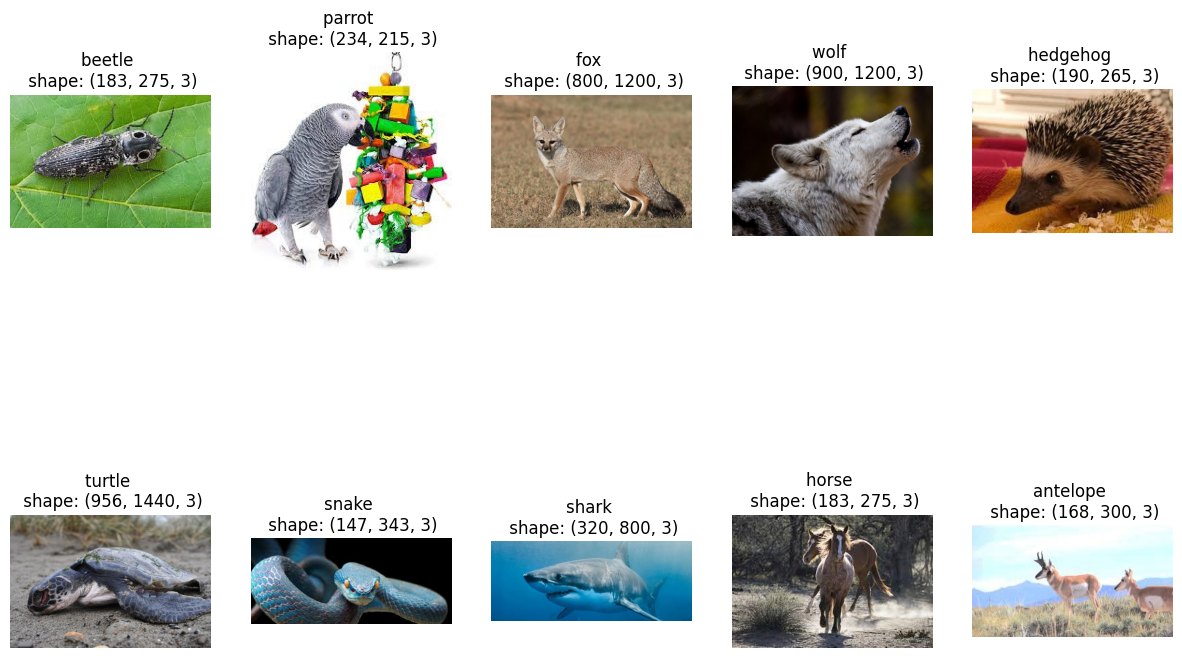

In [5]:
# Visualize some sample images form the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [6]:
# Preprocessing the data
# Define image size and batch_size
img_size = (224,224)
batch_size = 64

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split =0.1
)

#Creating training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [7]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)

#Extract class names
class_names = list(class_indices.keys())
print("class_name:",class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [9]:
# Load Model MobileNetv2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # output layer

#create  the final model
model= Model(inputs=base_model.input, outputs=predictions)

#compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 900ms/step - accuracy: 0.3346 - loss: 3.1258 - val_accuracy: 0.8164 - val_loss: 0.7659
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7031 - loss: 1.0751

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7031 - loss: 1.0751 - val_accuracy: 0.8047 - val_loss: 0.7958
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8238 - loss: 0.6191 - val_accuracy: 0.8125 - val_loss: 0.6409
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8750 - loss: 0.5193 - val_accuracy: 0.8223 - val_loss: 0.6196
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 554ms/step - accuracy: 0.8901 - loss: 0.3635 - val_accuracy: 0.8438 - val_loss: 0.5872
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8438 - loss: 0.4318 - val_accuracy: 0.8379 - val_loss: 0.5727
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 515ms/step - accuracy: 0.9412 - loss: 0.2225 - val_accuracy: 0.8574 - val_loss: 0.5743
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9062 - loss: 0.2820 - val_accuracy: 0.8555 - val_loss: 0.5849
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.9584 - loss: 0.1618 - val_accuracy: 0.8418 - val_l

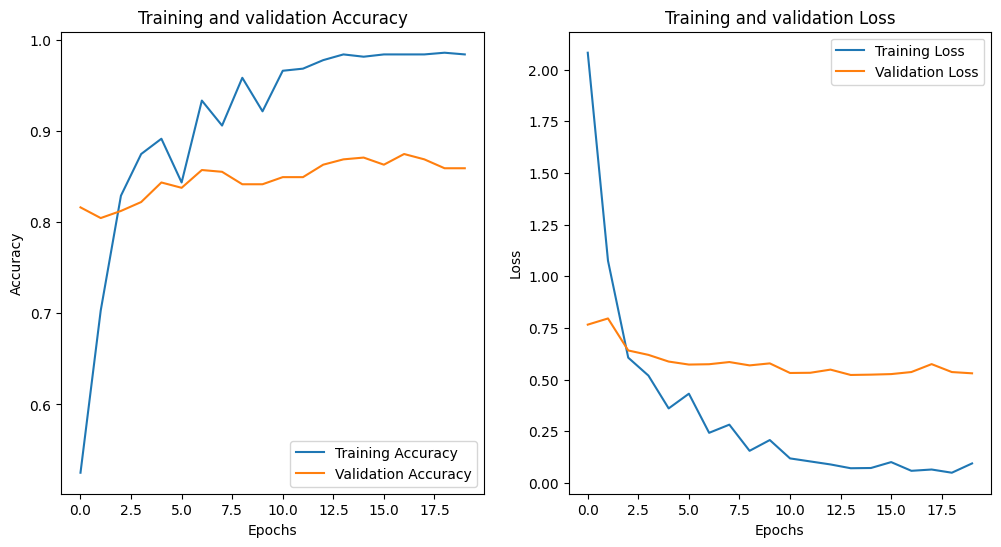

In [11]:
# Evaluate the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 848ms/step - accuracy: 0.8654 - loss: 0.5412
Validation Loss: 0.5174734592437744
Validation Accuracy: 0.8611111044883728


In [13]:
# Save the model
model.save('MCAR.keras')

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
  img=image.load_img(img_path, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions)]

  plt.imshow(img)
  plt.title(f'Predicted Class: {predicted_class}')
  plt.axis('off')
  plt.show()


In [15]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/leopard')

['2a41aeb776.jpg',
 '6ca023099a.jpg',
 '8a0751ed41.jpg',
 '6b0f0c2480.jpg',
 '9b6a2b1e8f.jpg',
 '4aefd7bcf1.jpg',
 '25aaedbf97.jpg',
 '20a83ea83f.jpg',
 '1dc348f0f4.jpg',
 '8b94deebeb.jpg',
 '1edb3ca86b.jpg',
 '4cc4005bf2.jpg',
 '3d912d69d7.jpg',
 '11dfaa6649.jpg',
 '9cc45df890.jpg',
 '9fa3adaf8a.jpg',
 '1aaf570d5b.jpg',
 '0cf927aad7.jpg',
 '2e68169f86.jpg',
 '7af6bdc5d4.jpg',
 '8f80468167.jpg',
 '6ecdb7f0b1.jpg',
 '3c2367666e.jpg',
 '3eda972ec6.jpg',
 '1d288afed5.jpg',
 '8e40fd968d.jpg',
 '5f59e752ec.jpg',
 '4f9c2e29c4.jpg',
 '10c84dc56f.jpg',
 '20af717417.jpg',
 '3d12d9e22c.jpg',
 '3a5a6e96ff.jpg',
 '9e8816a30c.jpg',
 '6c71261ce7.jpg',
 '1f0417beb2.jpg',
 '8b81792b48.jpg',
 '7f531deb20.jpg',
 '0dcd51602e.jpg',
 '2b9f5e3bd0.jpg',
 '6e2781163c.jpg',
 '3caadd5fae.jpg',
 '08e4bc108d.jpg',
 '0a60fc5f3f.jpg',
 '1aa9dfca2f.jpg',
 '16fd984d50.jpg',
 '16c517b41f.jpg',
 '0d3ee34d42.jpg',
 '0eb956c38c.jpg',
 '9d98548ce5.jpg',
 '8f88696942.jpg',
 '6a1e98348e.jpg',
 '2bf93ecede.jpg',
 '2e61139241

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


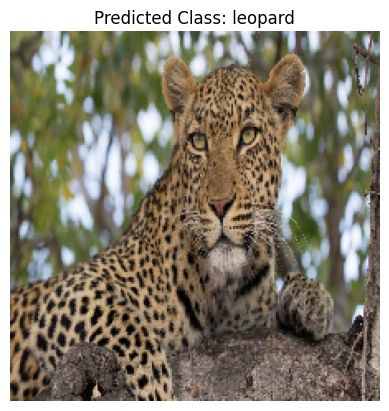

In [17]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/leopard/7af6bdc5d4.jpg')